# Basic Stacking Model - Diagram
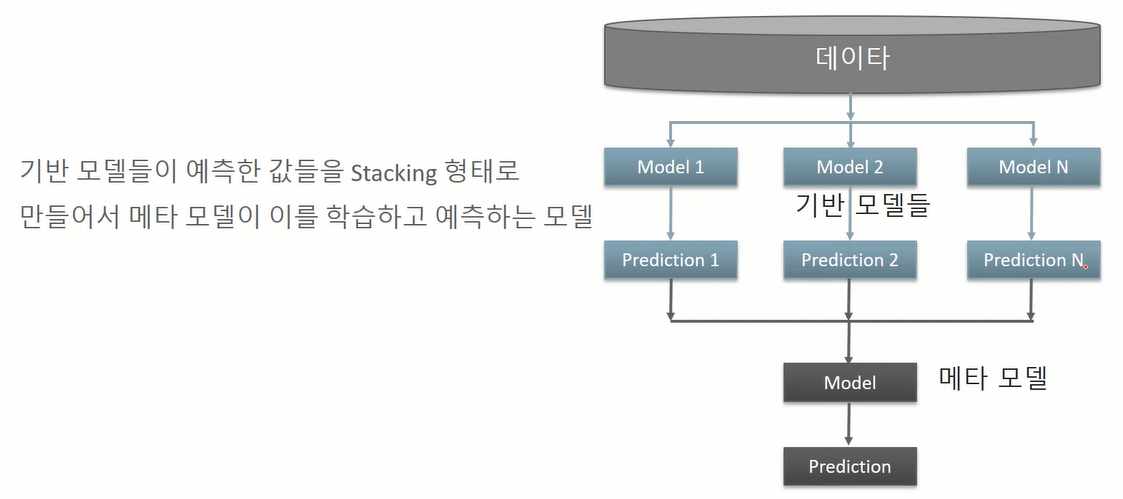
- 개별 모델들이 예측한 값을 기반으로 메타 모델이 **다시 학습하고 다시 예측**
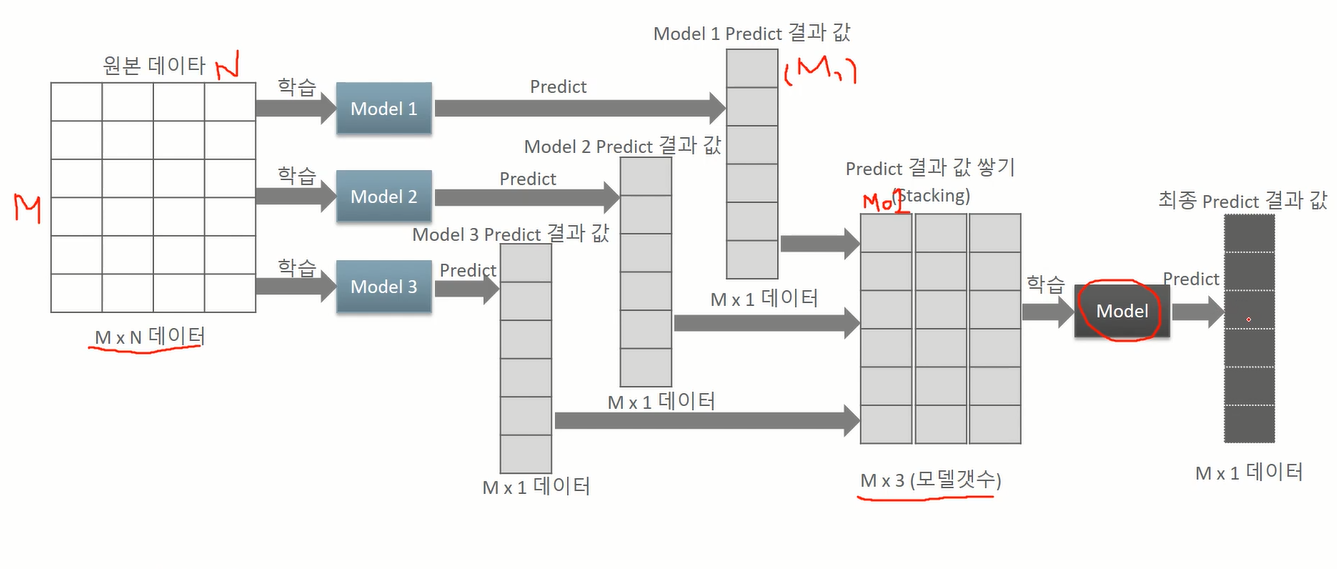
- 개별 모델보다 성능이 좋다고 보장할 수는 없다

In [1]:
import numpy as np

# 개별 모델들
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 메타 모델
from sklearn.linear_model import LogisticRegression

# 데이터 세트
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [2]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)


In [3]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [4]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


**개별 모델의 예측 결과(▲)를 메타 모델이 학습할 수 있도록 스태킹 형태로 재 생성**
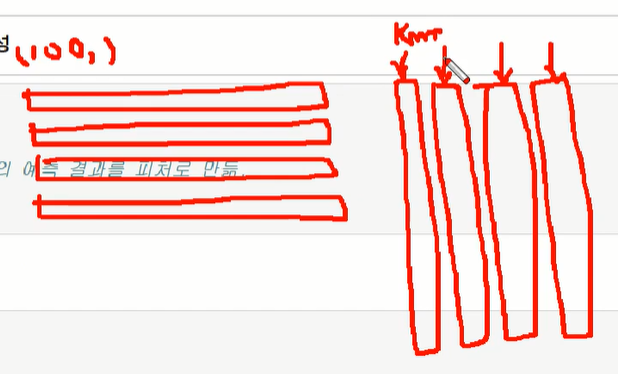

In [5]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [6]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9649


### CV(교차 검증) 셋 기반의 Stacking
개별 모델들이 각각 교차 검증으로 (메타 모델을 위한) 학습용 스태킹 데이터 생성과 에측을 위한 테스트용 스태킹 데이터를 생성한 뒤, 이를 기반으로 메타 모델이 학습/예측하는 것

1. [스텝1] 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성합니다.
2. [스텝2] 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 스태킹 형태로 합쳐 메타 모델이 학습할 최종_학습용_데이터_세트.zip을 생성합니다.

|**첫 번째 K Fold**|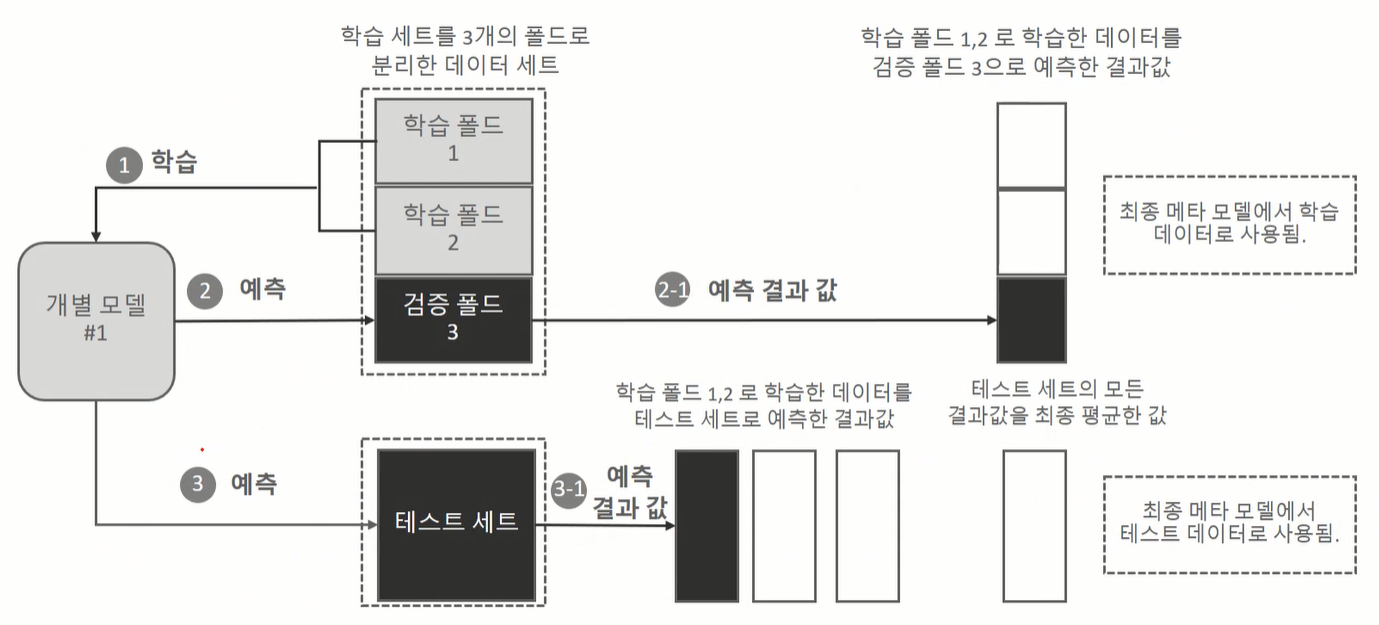|
|:-|----------|
|**두 번째 K Fold**|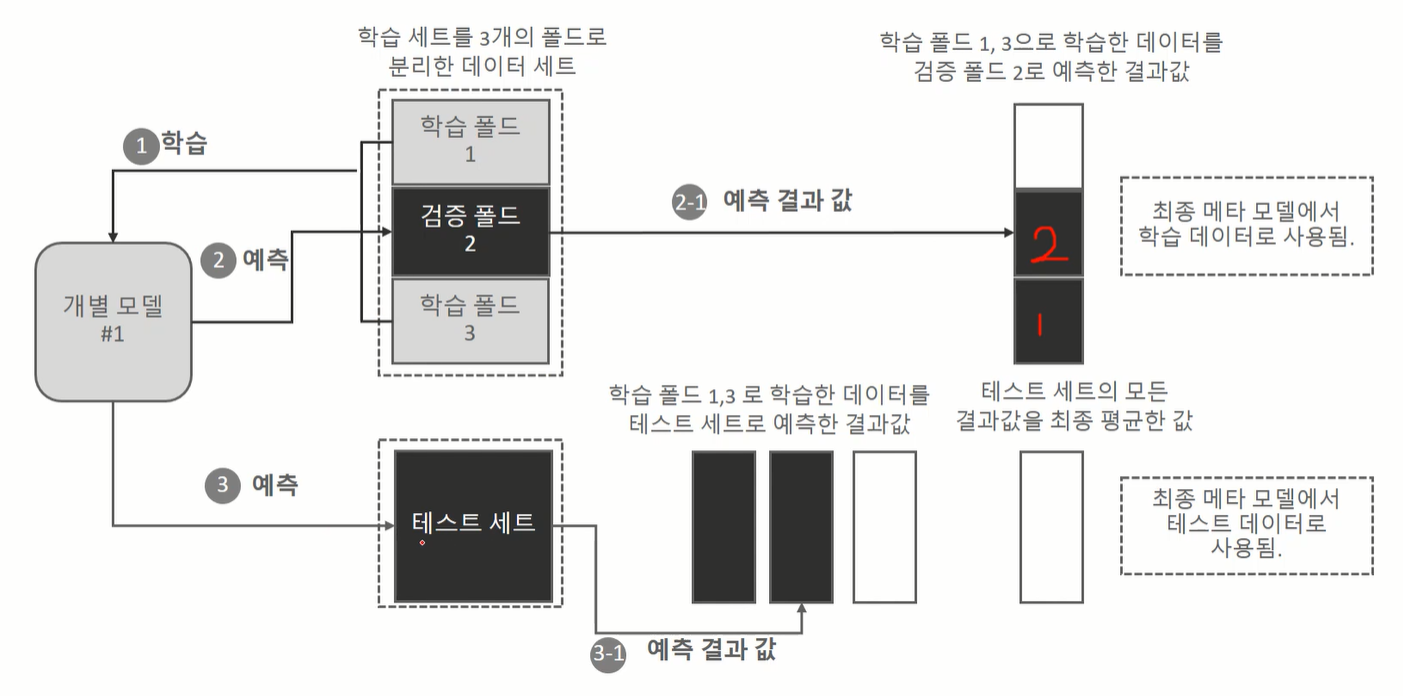|
|**세 번째 K Fold**|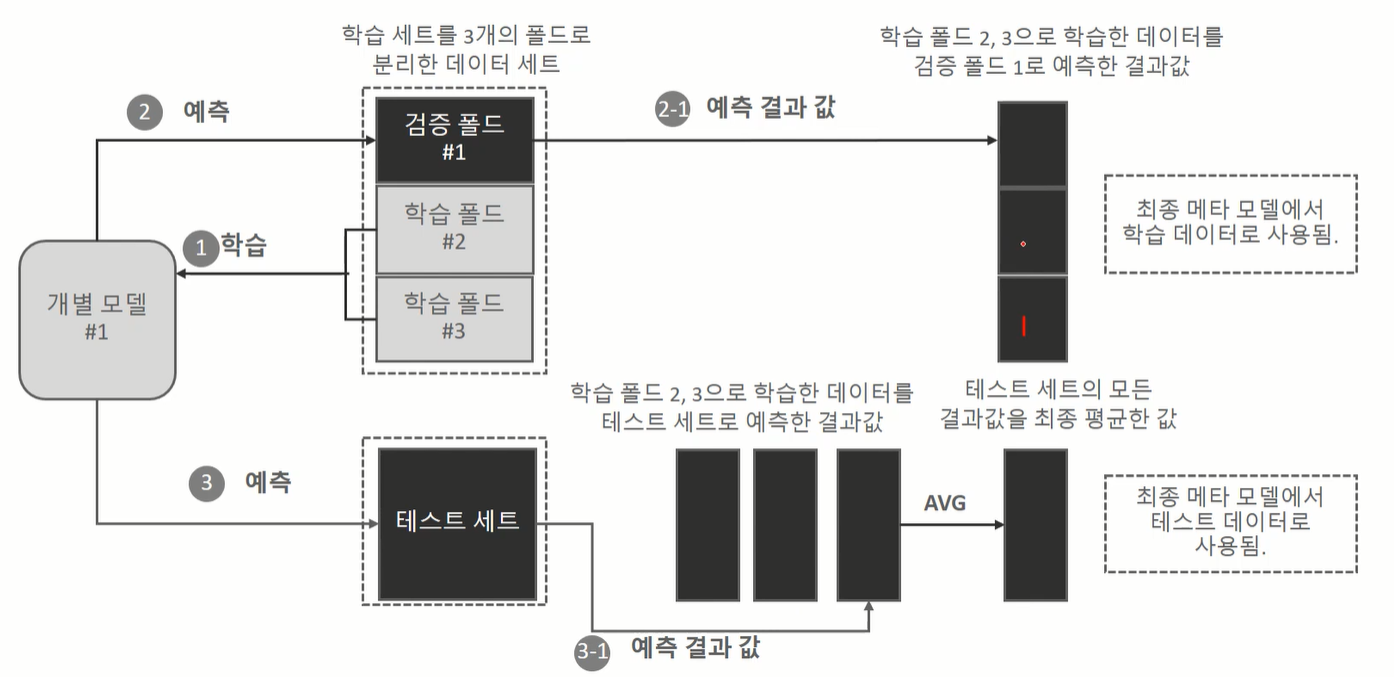|

#### 전체
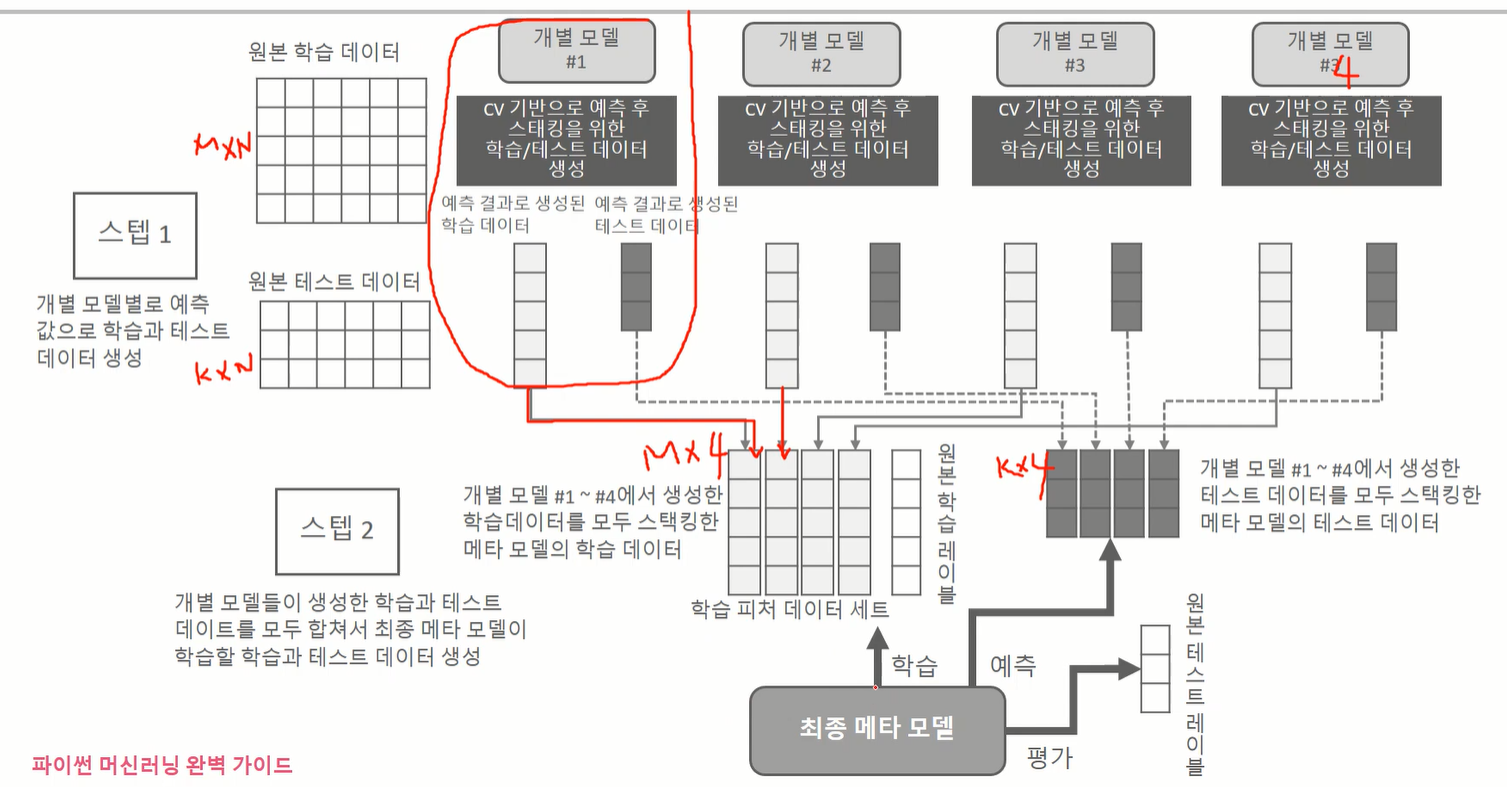

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 )) # 2차원
    test_pred = np.zeros((X_test_n.shape[0],n_folds)) # 테스트 사이즈 * 폴드 개수 7개
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [8]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [9]:
# 합침
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [10]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

# 원본과 비교
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
